**Importing Dependecies**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.io
import numpy as np
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision import datasets
matplotlib.style.use('ggplot')
from torch.utils.data import DataLoader

**Helper Function**

In [2]:
#for plotting 
def set_default(figsize=(0, 10), dpi=100):    
    plt.rc('axes', facecolor='white')
    plt.rc('figure', facecolor='white')
    plt.rc('figure', figsize=figsize, dpi=dpi)

**Loading data**

In [3]:
data = scipy.io.loadmat('burgers_shock.mat')


Configuration

In [4]:
print(data['x'].shape)
print(data['t'].shape)
print(data['usol'].shape)

(256, 1)
(100, 1)
(256, 100)


In [5]:
x_dir = data['x']
time = data['t']
usolution = data['usol']


In [6]:
#Converting it to a tensor
usol_train=torch.from_numpy(usolution)
usol_train=np.reshape(usol_train,(1,25600))
usol_train=usol_train.float()
usol_train.shape



torch.Size([1, 25600])

**Plotting Original Solution**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: The following kwargs were not used by contour: 'lw'
  This is separate from the ipykernel package so we can avoid doing imports until


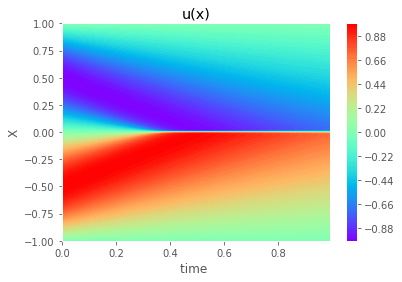

In [7]:
Time,X_coordinate = np.meshgrid(time,x_dir)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(Time, X_coordinate,np.reshape((usol_train),(256,100)),100,cmap='rainbow',lw=0)
ax.set_title('u(x)')
ax.set_xlabel('time ')
ax.set_ylabel('X')
plt.colorbar(cp)
plt.show()

**Data Loaders**

In [8]:
train_loader = DataLoader(dataset=usol_train,  shuffle=True)
train_loader


**Setting up a Model**

In [9]:
features =1
# define a simple linear VAE
class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__() 
        # encoder
        self.enc1 = nn.Linear(in_features=25600, out_features=500)
        self.enc2 = nn.Linear(in_features=500, out_features=features*2)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=features, out_features=500)
        self.dec2 = nn.Linear(in_features=500, out_features=25600)


    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample

 
    def forward(self, x):

        # encoding
        x = F.relu(self.enc1(x))        
        x = self.enc2(x).view(-1, 2, features)
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
 
        # decoding               
        x = self.dec1(z)               
        reconstruction = self.dec2(x)
        return reconstruction, mu, log_var


    def decode(self, z):
        x=self.dec1(z)
        return self.dec2(x)

    def sample_for_datagen(self, n_samples):
        z = torch.randn((n_samples, features))
        return self.decode(z)

In [10]:
# leanring parameters
lr = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Initializing the Model, the Optimizer and the Loss Function**

In [11]:
model = LinearVAE()
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

**Defining the final loss function**

In [12]:
def final_loss(mse_loss, mu, logvar):
    """
    This function will add the reconstruction loss (MSELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param mse_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    MSE = mse_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

**Training function**

In [13]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i,data in tqdm(enumerate(dataloader), total=int(len(usol_train)/dataloader.batch_size)):
        data = data
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        mse_loss = criterion(reconstruction, data)
        loss = final_loss(mse_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

**Training the model**

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.5809
Epoch 2 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 14.2097
Epoch 3 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 2.5136
Epoch 4 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.6722
Epoch 5 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.6572
Epoch 6 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.7168
Epoch 7 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.6477
Epoch 8 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.6977
Epoch 9 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.6001
Epoch 10 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.5672
Epoch 11 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.5300
Epoch 12 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.4987
Epoch 13 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.4579
Epoch 14 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.4994
Epoch 15 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.4354
Epoch 16 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.4847
Epoch 17 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.3836
Epoch 18 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.3394
Epoch 19 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.3120
Epoch 20 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.3007
Epoch 21 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.5961
Epoch 22 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.2799
Epoch 23 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.2676
Epoch 24 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.2573
Epoch 25 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.2483
Epoch 26 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.3734
Epoch 27 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.2360
Epoch 28 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.3622
Epoch 29 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.3464
Epoch 30 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.2841
Epoch 31 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.2381
Epoch 32 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.2051
Epoch 33 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.2075
Epoch 34 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.2478
Epoch 35 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.3143
Epoch 36 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.2429
Epoch 37 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.1604
Epoch 38 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.1602
Epoch 39 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.1575
Epoch 40 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.3210
Epoch 41 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.1377
Epoch 42 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.1342
Epoch 43 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.1424
Epoch 44 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.1261
Epoch 45 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.1282
Epoch 46 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.1451
Epoch 47 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.1422
Epoch 48 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.1072
Epoch 49 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.2355
Epoch 50 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.1300
Epoch 51 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.1760
Epoch 52 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.1512
Epoch 53 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0932
Epoch 54 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.1099
Epoch 55 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.1006
Epoch 56 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.1034
Epoch 57 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0743
Epoch 58 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0743
Epoch 59 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0706
Epoch 60 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.1146
Epoch 61 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0824
Epoch 62 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0834
Epoch 63 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0704
Epoch 64 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0746
Epoch 65 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0604
Epoch 66 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0526
Epoch 67 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.1656
Epoch 68 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0627
Epoch 69 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0493
Epoch 70 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.1098
Epoch 71 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.1145
Epoch 72 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0405
Epoch 73 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0413
Epoch 74 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0430
Epoch 75 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.1486
Epoch 76 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0330
Epoch 77 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0363
Epoch 78 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0310
Epoch 79 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0286
Epoch 80 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0377
Epoch 81 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0438
Epoch 82 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0664
Epoch 83 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0430
Epoch 84 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0235
Epoch 85 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0284
Epoch 86 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0290
Epoch 87 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0656
Epoch 88 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0306
Epoch 89 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0182
Epoch 90 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0194
Epoch 91 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0423
Epoch 92 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0244
Epoch 93 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0355
Epoch 94 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0152
Epoch 95 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0515
Epoch 96 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0626
Epoch 97 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0222
Epoch 98 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0565
Epoch 99 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0263
Epoch 100 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0112
Epoch 101 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0111
Epoch 102 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0467
Epoch 103 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0262
Epoch 104 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0367
Epoch 105 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0099
Epoch 106 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0266
Epoch 107 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0194
Epoch 108 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.1160
Epoch 109 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0362
Epoch 110 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0078
Epoch 111 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0171
Epoch 112 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0097
Epoch 113 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0219
Epoch 114 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0081
Epoch 115 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0114
Epoch 116 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0644
Epoch 117 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0536
Epoch 118 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0095
Epoch 119 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0051
Epoch 120 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0098
Epoch 121 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0137
Epoch 122 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0046
Epoch 123 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0058
Epoch 124 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0049
Epoch 125 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0046
Epoch 126 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0127
Epoch 127 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0091
Epoch 128 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0057
Epoch 129 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0455
Epoch 130 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0252
Epoch 131 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0088
Epoch 132 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0038
Epoch 133 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0032
Epoch 134 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0053
Epoch 135 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0510
Epoch 136 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0051
Epoch 137 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0099
Epoch 138 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0090
Epoch 139 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0026
Epoch 140 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0027
Epoch 141 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0024
Epoch 142 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0026
Epoch 143 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0024
Epoch 144 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0033
Epoch 145 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0021
Epoch 146 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0027
Epoch 147 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0084
Epoch 148 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0022
Epoch 149 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0139
Epoch 150 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0107
Epoch 151 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0020
Epoch 152 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0021
Epoch 153 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0460
Epoch 154 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0016
Epoch 155 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0081
Epoch 156 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0109
Epoch 157 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0049
Epoch 158 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0121
Epoch 159 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0100
Epoch 160 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0019
Epoch 161 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0069
Epoch 162 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0023
Epoch 163 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0039
Epoch 164 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0026
Epoch 165 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0020
Epoch 166 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0018
Epoch 167 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0029
Epoch 168 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0032
Epoch 169 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0011
Epoch 170 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0078
Epoch 171 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0031
Epoch 172 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0051
Epoch 173 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0019
Epoch 174 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0107
Epoch 175 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0213
Epoch 176 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0085
Epoch 177 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0054
Epoch 178 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0120
Epoch 179 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0132
Epoch 180 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0010
Epoch 181 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0043
Epoch 182 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0041
Epoch 183 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0028
Epoch 184 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0035
Epoch 185 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0075
Epoch 186 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0022
Epoch 187 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0129
Epoch 188 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0095
Epoch 189 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0018
Epoch 190 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0044
Epoch 191 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0054
Epoch 192 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0009
Epoch 193 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0017
Epoch 194 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0010
Epoch 195 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0011
Epoch 196 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0019
Epoch 197 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0009
Epoch 198 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0040
Epoch 199 of 200


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.0039
Epoch 200 of 200


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]

Train Loss: 0.0009
CPU times: user 46.9 s, sys: 949 ms, total: 47.8 s
Wall time: 48.3 s


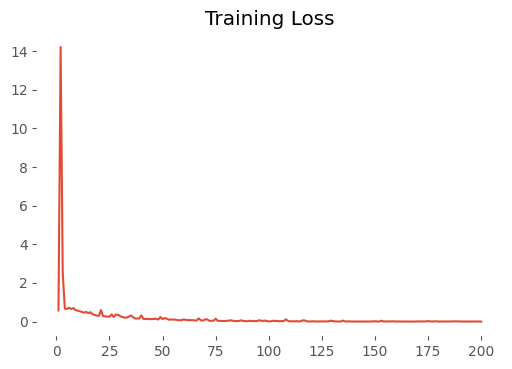

In [14]:
%%time
train_loss = []

epochs=200
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader)
    #val_epoch_loss = validate(model, test_loader)
    train_loss.append(train_epoch_loss)
    #val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    
    
    #print(f"Val Loss: {val_epoch_loss:.4f}")

set_default(figsize=(6, 4), dpi=100)

plt.title('Training Loss')
plt.plot(range(1, epochs+1), train_loss)

**Generating samples from latent space vector**

In [15]:
samples = model.sample_for_datagen(20)
samples=samples.detach().numpy()
samples.shape


(20, 25600)

**Plotting generated samples**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: The following kwargs were not used by contour: 'lw'
  import sys


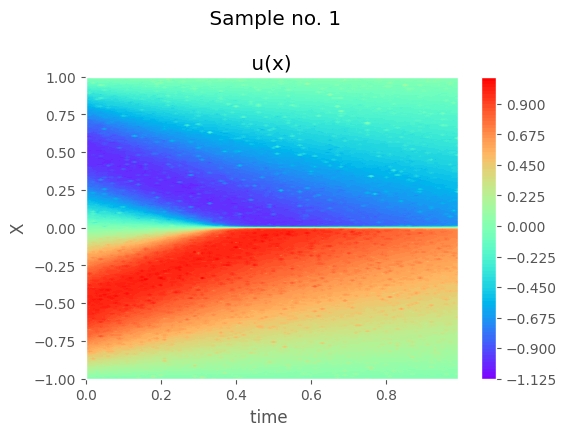

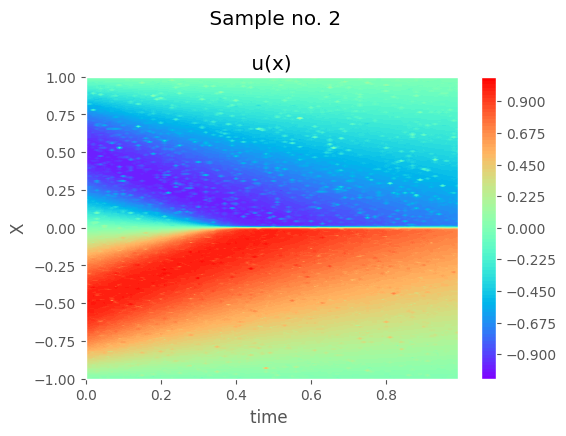

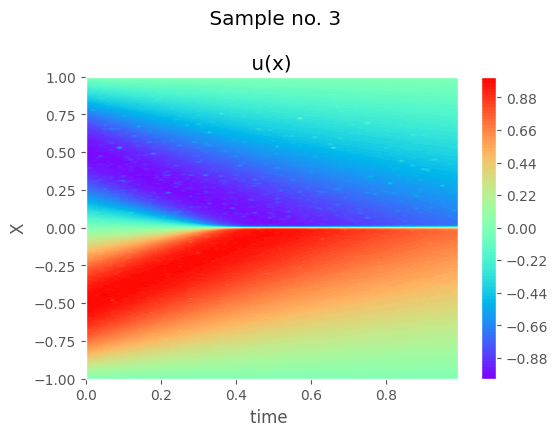

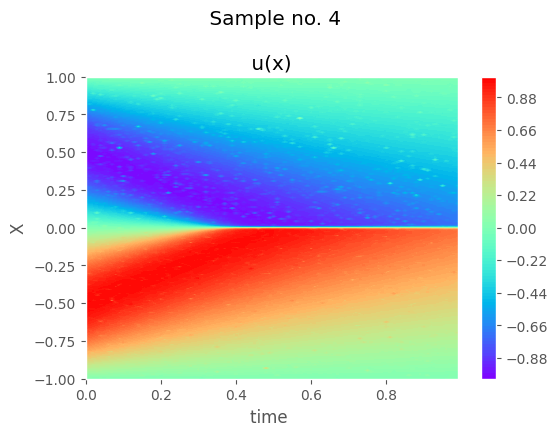

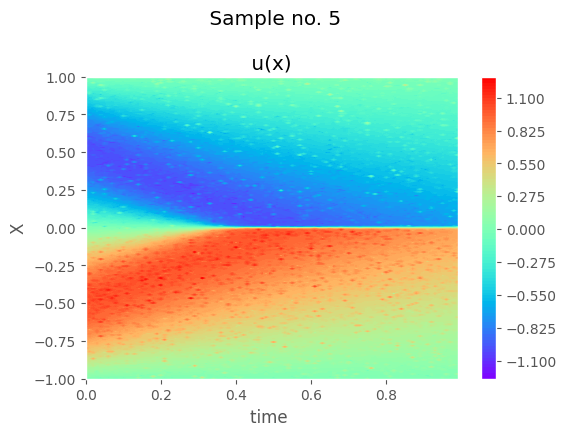

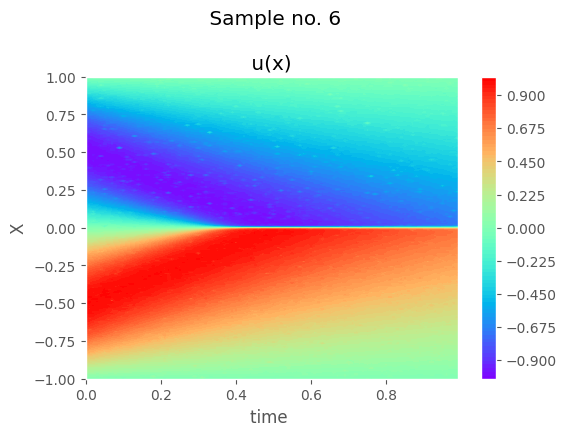

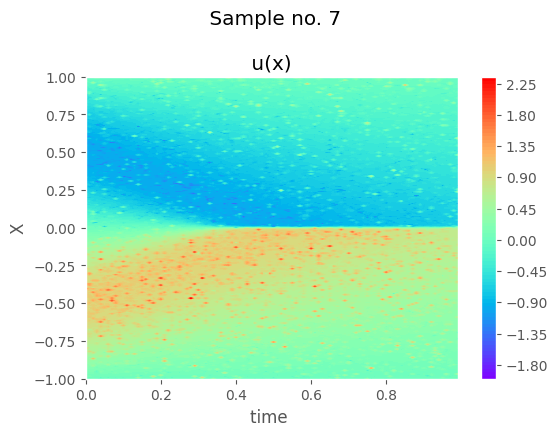

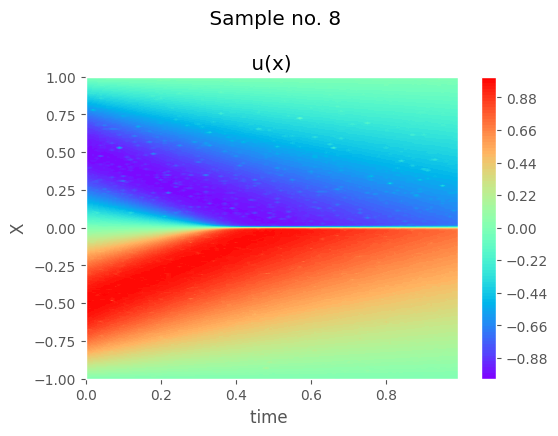

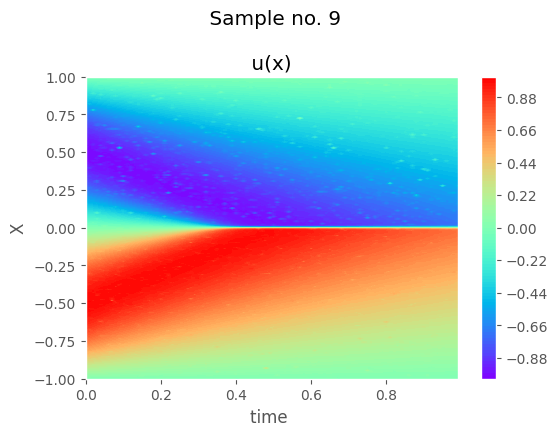

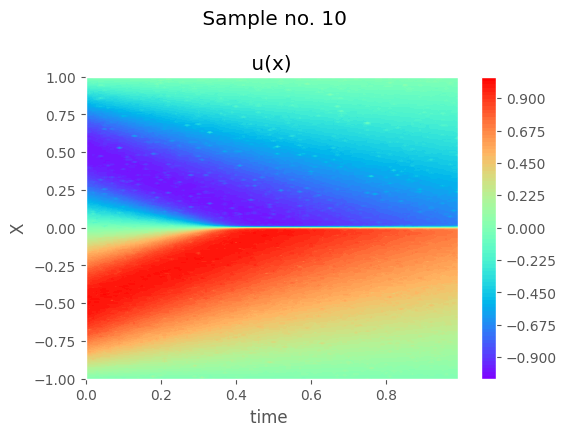

In [16]:

i=0

while i<10:
  fig,ax=plt.subplots(1,1)  
  plt.grid(color='w', linestyle='solid')
  cp = ax.contourf( Time,X_coordinate,np.reshape(samples[i],(256,100)),100,cmap='rainbow',lw=0)
  ax.set_title( ' Sample no. '+str(i+1)+ '\n\n u(x) ')
  
  ax.set_xlabel('time ')
  ax.set_ylabel('X')
  plt.colorbar(cp)
  plt.show()
  i=i+1



 **THE END**